# Simulation setup

Load global analysis variables:

In [1]:
%run standard.py

In [2]:
import re, os, sys, pickle, pickle, math
from pathlib import Path
import numpy as np
import pandas as pd
import scipy
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from ChromosomeWindows import window
import genominterv

/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
%%html
<style> table { font-variant-numeric: tabular-nums; } </style>

Import variables global to the entire analysis:

In [4]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [5]:
if str(ag.scripts_dir) not in sys.path:
    sys.path.append(str(ag.scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

Plotting setup:

In [6]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
# from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # seaborn niceness
sns.set_style("whitegrid")
sns.set_context("notebook")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

def abline(slope, intercept, ax=None):
    "Add a straight line through the plot"
    if ax is None:
        ax = plt.gca()
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', color='grey')

In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/e

Ignore warnings:

In [7]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Load meta data

Easy loading of meta data in a consistent manner across code

In [8]:
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=ag.meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Load swept regions

To account for the recombination rate and genetic diversity caracteristic of the ECH regions we operationally define these regions as the ones where at least 10% of individual chromososomes are called as ECH:

In [9]:
extended_peak_regions_10 = pd.read_hdf(ag.results_dir / f'extended_peak_regions_{ech_calling_tag}_10%.hdf')
extended_peak_regions_10['chrom'] = 'chrX'
ech_total_10 = (extended_peak_regions_10.end_pos - extended_peak_regions_10.start_pos).sum()
print("Total ECH 10% region:", ech_total_10/1e6, 'Mb')

Total ECH 10% region: 17.5 Mb


This is how many percent of the total chromosome length where ECHs are called:

In [10]:
ech_total_10 / hg19_chrom_sizes.hg19_chrom_sizes['chrX'] * 100

11.270649117257

## Between-population pi on chromosome 7 to match in simulations

Mean of pairwise differences between nonAfricans (using one pseudohaploid from each analyzed male)

In [11]:
pwdiff_data_chr7 = pd.read_hdf('/home/kmt/simons/faststorage/people/kmt/steps/chr7_pwdiff_stores/dist_data_chr7_100kb.store')

In [12]:
autosome_pi = (pwdiff_data_chr7
      .loc[(pwdiff_data_chr7.region_1 != 'Africa') & (pwdiff_data_chr7.region_2 != 'Africa')]
      .dist
      .mean()
     )
del pwdiff_data_chr7

In [13]:
autosome_pi

0.000813939675808206

In [14]:
#autosome_pi = 0.000813939675808206

## Within-population pi for chromosome X and 7 for X/A ratios

We use both males and females from the analyzed populations.

In [75]:
pi_data_chrX = pd.read_hdf(ag.results_dir / 'pi_data_chrX.hdf')
pi_data_chr7 = pd.read_hdf(ag.results_dir / 'pi_data_chr7.hdf')

In [76]:
with open(str(ag.results_dir / 'pi_filter_mask_chrX.npy'), 'rb') as f:
    pi_filter_mask_chrX = np.load(f)
with open(str(ag.results_dir / 'pi_filter_mask_chr7.npy'), 'rb') as f:
    pi_filter_mask_chr7 = np.load(f)    

In [77]:
cols = ['chrom', 'region', 'population', 'pi']
df = (pd.concat([pi_data_chrX.loc[~pi_filter_mask_chrX, cols], 
                 pi_data_chr7.loc[~pi_filter_mask_chr7, cols]])
      .groupby(['chrom', 'region', 'population'], observed=True)
      .aggregate(np.nanmean)
      .reset_index()
     )

df = (df
      .pivot(index=['region', 'population'], columns='chrom', values='pi')
      .reset_index()
      .assign(x_a_ratio=lambda df: df['X'] / df['7'])
     )
df.head()

chrom,region,population,7,X,x_a_ratio
0,Africa,BantuHerero,0.001023,0.000689,0.673914
1,Africa,BantuTswana,0.001069,0.000708,0.662027
2,Africa,Biaka,0.001069,0.000676,0.632462
3,Africa,Dinka,0.000968,0.000643,0.664756
4,Africa,Esan,0.001002,0.000662,0.661224


In [84]:
westeurasian_autosome_pi = df.loc[df.region == 'WestEurasia']['7'].median()
westeurasian_autosome_pi

0.0007806335405185635

We use the median 7/X ratio across populations included in our analysis.

African populations:

In [18]:
afr_x_auto = df.loc[df.region == 'Africa'].x_a_ratio.median()
afr_x_auto

0.6521455877528287

Non-African populations:

In [19]:
nonafr_x_auto = df.loc[df.region != 'Africa'].x_a_ratio.median()
nonafr_x_auto

0.5132439354345538

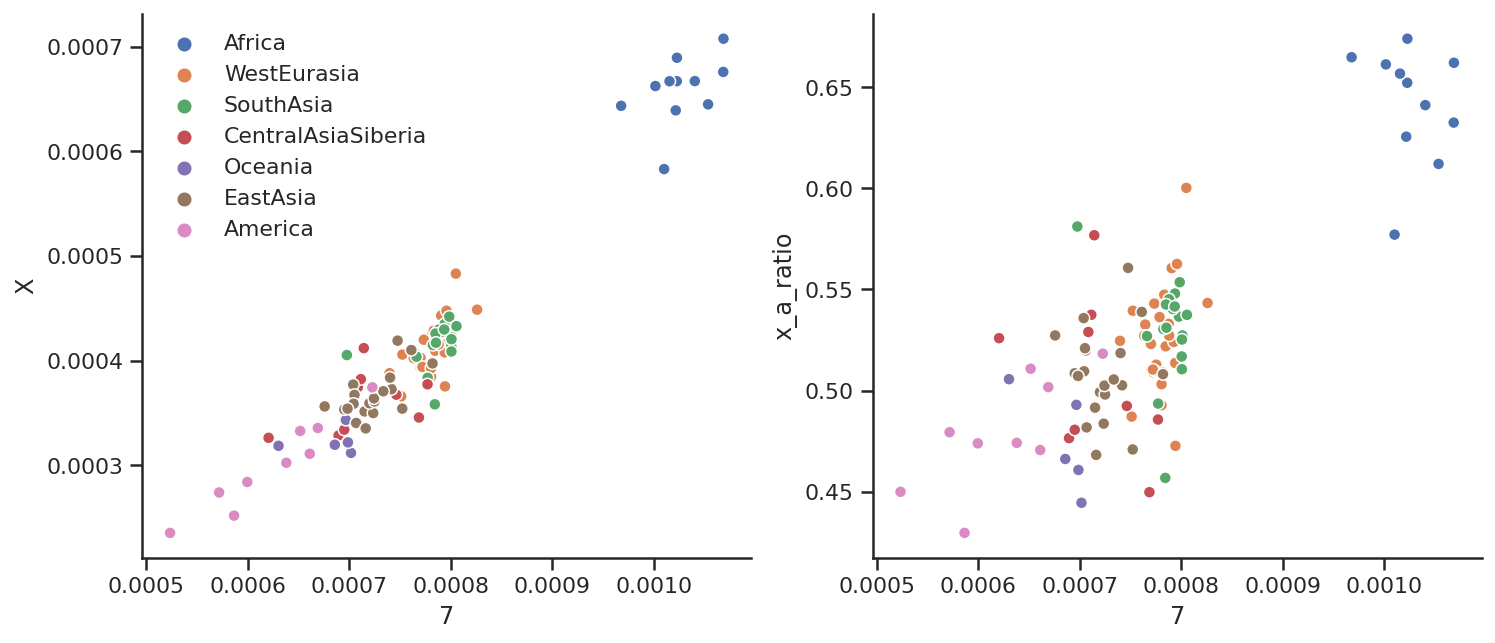

In [20]:
with sns.axes_style('ticks'):
    fig, (ax1, ax2) = fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    sns.scatterplot(data=df, x='7', y='X', hue='region', ax=ax1)    
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles=handles[1:], labels=labels[1:], frameon=False)    

    sns.scatterplot(data=df, x='7', y='x_a_ratio', hue='region', ax=ax2, legend=False)

    sns.despine()

Mean X/7 ratio per region:

In [21]:
df.groupby('region').mean().reset_index()

chrom,region,7,X,x_a_ratio
0,Africa,0.001027,0.000659,0.641725
1,WestEurasia,0.000778,0.000409,0.525603
2,SouthAsia,0.000786,0.000417,0.530305
3,CentralAsiaSiberia,0.000714,0.000362,0.507436
4,Oceania,0.000683,0.000323,0.474063
5,EastAsia,0.000724,0.000367,0.507007
6,America,0.000625,0.000300,0.478766


Within- vs between-population pi:

In [22]:
mean_nonafr_withinpop_pi = df.loc[df.region != 'Africa']['7'].mean()
mean_nonafr_withinpop_pi

0.0007406027944883504

How much is between-population pi larger than within-population pi:

In [23]:
(autosome_pi - mean_nonafr_withinpop_pi) / mean_nonafr_withinpop_pi

0.09902323062461688

## Pairwise diffs between African males in ECH regions

In [24]:
dist_afr_chrX = (pd.read_hdf(ag.steps_dir / 'male_dist_admix_masked_stores/male_dist_data_chrX_100kb.hdf')
            .loc[lambda df: (df.region_1 == 'Africa') & (df.region_2 == 'Africa')]
           )
dist_nonafr_chrX = (pd.read_hdf(ag.steps_dir / 'male_dist_admix_masked_stores/male_dist_data_chrX_100kb.hdf')
            .loc[lambda df: (df.region_1 != 'Africa') & (df.region_2 != 'Africa')]
           )

Means across all non-Africans and Africans:

In [25]:
afr_mean_dist_chrX = dist_afr_chrX.dist.mean()
nonafr_mean_dist_chrX = dist_nonafr_chrX.dist.mean()

afr_mean_dist_chrX, nonafr_mean_dist_chrX

(0.0007654297, 0.00046199272)

Means in 10% extended regions:

In [26]:
lst = list()
for tup in extended_peak_regions_10.itertuples():
    lst.append(dist_afr_chrX.loc[(dist_afr_chrX.start >= tup.start_pos) & (dist_afr_chrX.end <= tup.end_pos)])
afr_dist_regions_chrX = pd.concat(lst)

afr_mean_dist_in_regions_chrX = afr_dist_regions_chrX.dist.mean()

If we assume that the regions have not experienced any sweeps in Africa, we can compute the local Ne of regions relative to the global chromosome Ne:

In [27]:
afr_mean_dist_in_regions_chrX / afr_mean_dist_chrX

0.7102142

This implies that background Ne in the regions is **0.71** of the chromosome average. We use this number in simulations to account for any lower Ne in the ECH regions.

## Simulations

We simulate 200,000 generations, correspoding to roughly 10 Ne. Most lineages should have coalesced by 6Ne.

In [140]:
#ag.auto_mut_per_year = 5.25e-10

In [141]:
# Number of simulated generations
sim_generations = 200000 - 1
  
def years2gen(y):
    "Compute forwards generation from backwards time"
    return int(1 + sim_generations - y / ag.gen_time)

years2gen(sim_generations * ag.gen_time), years2gen(0), sim_generations * ag.gen_time

(1, 200000, 5799971)

Functions for Pool-Nielsen computations:

In [142]:
def get_epoques_from_demog(demography):
    epoques = list()
    g, n = list(zip(*demography))
    gens, Ns = [sim_generations-x for x in g][::-1], n[::-1]
    gens, Ns = [sim_generations-x for x in g][::-1], n[::-1]
    for i in range(len(gens)):
        if i == 0:
            epoques.append((gens[i], Ns[i]))
        elif i == len(gens) - 1:
            epoques.append((None, Ns[i]))    
        else:
            epoques.append((gens[i] - gens[i-1], Ns[i]))
    return epoques

def exp_coal(g, N):
    return 2*N - (g * np.exp(-g/(2*N))) / (1 - np.exp(-g/(2*N)))

def epoch(demog, h, i):
    g, N = demog[i]
    N *= h
    if i == len(demog)-1:
        return 2*N
    return (1-np.exp(-g/(2*N))) * exp_coal(g, N) + np.exp(-g/(2*N)) * (g + epoch(demog, h, i+1))

Test:

In [143]:
demog = [(1, 10000), (1000, 10000), (5000, 10000), (10000, 10000)]
epoques = get_epoques_from_demog(demog)
epoch(epoques, 1, 0) / 2

10000.0

### Sweeps

Compute generations for sweeps in Slim simulations (for adding to `workflow.py`):

In [144]:
# time points for starts fo simulated sweeps:
sweep_years = [30000, 50000, 70000, 90000]

sweep_generations = [years2gen(x) for x in sweep_years]
sweep_generations

[198965, 198275, 197586, 196896]

Functions for Pool-Nielsen computations:

### Global sample demography

In [145]:

#sampledemog_raw_data = pd.read_csv('/home/kmt/simons/faststorage/people/kmt/steps/smcpp/.csv')

sampledemog_raw_data = pd.read_csv('/home/kmt/simons/faststorage/people/kmt/steps/smcpp/step_0_100000_LP6005443-DNA_A06_LP6005443-DNA_D06_LP6005519-DNA_D05_LP6005443-DNA_D02_LP6005443-DNA_F08_LP6005441-DNA_E10/step_0_100000_LP6005443-DNA_A06_LP6005443-DNA_D06_LP6005519-DNA_D05_LP6005443-DNA_D02_LP6005443-DNA_F08_LP6005441-DNA_E10.csv')
#sampledemog_raw_data = pd.read_csv('/home/kmt/simons/faststorage/people/kmt/steps/smcpp/step_1_100000_LP6005443-DNA_A06_LP6005443-DNA_D06_LP6005519-DNA_D05_LP6005443-DNA_D02_LP6005443-DNA_F08_LP6005441-DNA_E10/step_1_100000_LP6005443-DNA_A06_LP6005443-DNA_D06_LP6005519-DNA_D05_LP6005443-DNA_D02_LP6005443-DNA_F08_LP6005441-DNA_E10.csv')
#sampledemog_raw_data = pd.read_csv('/home/kmt/simons/faststorage/people/kmt/steps/smcpp/step_100000_LP6005443-DNA_A06_LP6005443-DNA_D06_LP6005519-DNA_D05_LP6005443-DNA_D02_LP6005443-DNA_F08_LP6005441-DNA_E10/step_100000_LP6005443-DNA_A06_LP6005443-DNA_D06_LP6005519-DNA_D05_LP6005443-DNA_D02_LP6005443-DNA_F08_LP6005441-DNA_E10.csv')


#sampledemog_raw_data = pd.read_csv('/home/kmt/simons/faststorage/people/kmt/steps/_smcpp/step_100000_LP6005443-DNA_A06_LP6005443-DNA_D06_LP6005519-DNA_D05_LP6005443-DNA_D02_LP6005443-DNA_F08_LP6005441-DNA_E10/step_100000_LP6005443-DNA_A06_LP6005443-DNA_D06_LP6005519-DNA_D05_LP6005443-DNA_D02_LP6005443-DNA_F08_LP6005441-DNA_E10.csv')

sampledemog_data = DataFrame(dict(years=sampledemog_raw_data.x,
                               Ne=sampledemog_raw_data.y,
                               population=sampledemog_raw_data.label
                              ))
sampledemog_data['years'] = sampledemog_data.years.round(0).astype(int)
sampledemog_data['Ne'] = sampledemog_data.Ne.round(0).astype(int)
sampledemog_data.head()

,years,Ne,population
0,0,255480,nonAfr
1,1015,255480,nonAfr
2,1090,255480,nonAfr
3,1171,255480,nonAfr
4,1257,255480,nonAfr


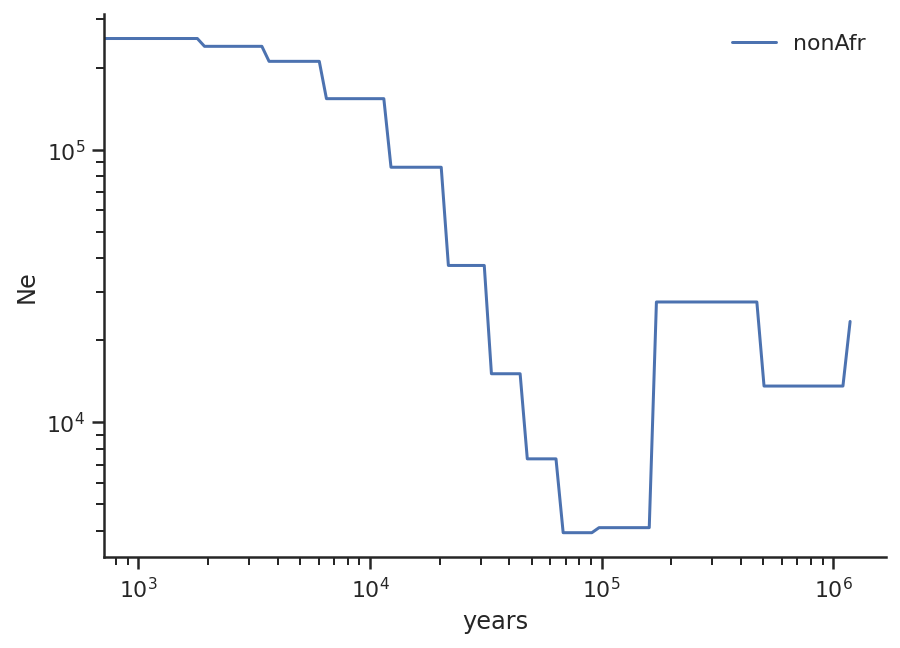

In [146]:
with sns.axes_style('ticks') :
    fig, ax = plt.subplots(figsize=(7,5))
    sns.lineplot(data=sampledemog_data, x='years', y='Ne', hue='population', ax=ax)
    ax.set_xscale('log')
    ax.set_yscale('log')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:], frameon=False)
    sns.despine()

In [147]:
years = sampledemog_data.loc[sampledemog_data.population == 'nonAfr', 'years']
n = sampledemog_data.loc[sampledemog_data.population == 'nonAfr', 'Ne']

If the mutation rate used to make the demography is larger than the one we use, then we need to increase the years and Ne accordingly (more time required to make up for smaller mutation rate):

In [148]:
years *= 5.25e-10 * 29 / (ag.auto_mut_per_year * ag.gen_time) 
n *= 5.25e-10 * 29 / (ag.auto_mut_per_year * ag.gen_time) 

In [149]:
# years *= 4.3e-10 * 29 / (ag.auto_mut_per_year * ag.gen_time) 
# n *= 4.3e-10 * 29 / (ag.auto_mut_per_year * ag.gen_time) 

In [150]:
# years *= 5 / 5.25
# n *= 5 / 5.25

In [151]:
years.at[len(years)-1] = sim_generations * ag.gen_time

In [152]:
sampledemog_auto_demography = list(zip(list(map(int, reversed(years))), list(map(int, reversed(n)))))

sampledemog_slim_demography = [(years2gen(y), int(n)) for (y, n) in sampledemog_auto_demography]

Compute expected pi:

In [153]:
epoques = get_epoques_from_demog(sampledemog_slim_demography)
pool_nielsen_expected_pi = 2 * ag.auto_mut_per_year * ag.gen_time * epoch(epoques, 1, 0)
pool_nielsen_expected_pi, autosome_pi

(0.0008844830430318864, 0.000813939675808206)

Do pool-nielsen correction:

In [154]:
pool_nielsen_correction = autosome_pi / pool_nielsen_expected_pi    
pool_nielsen_correction

0.9202433921380025

In [155]:
sampledemog_auto_demography_corrected = [(int(round((g*pool_nielsen_correction))), int(round(N*pool_nielsen_correction))) for (g, N) in sampledemog_auto_demography]
sampledemog_auto_demography_corrected[0] = (sampledemog_auto_demography[0][0], sampledemog_auto_demography_corrected[0][1]) 
assert sampledemog_auto_demography_corrected == sorted(sampledemog_auto_demography_corrected, reverse=True)

In [156]:
sampledemog_slim_demography_corrected = [(years2gen(y), int(n)) for (y, n) in sampledemog_auto_demography_corrected]

In [157]:
epoques = get_epoques_from_demog(sampledemog_slim_demography_corrected)
pool_nielsen_correction, 2 * ag.auto_mut_per_year * ag.gen_time * epoch(epoques, 1, 0), autosome_pi, epoch(epoques, 1, 0) / 2

(0.9202433921380025,
 0.0008139953417894936,
 0.000813939675808206,
 13365.33383296806)

### Terhorst demography

In this paper, the demography is based on a mutation rate per generation of 1.25 × 10−8. That is roughly the same as in my analysis:

In [158]:
ag.auto_mut_per_year * ag.gen_time

1.5225870000000002e-08

In [159]:
terhorst_raw_data = pd.read_csv('/home/kmt/simons/faststorage/people/kmt/data/terhorst_2017_fig5.csv')

In [160]:
terhorst_data = DataFrame(dict(years=terhorst_raw_data.x,
                               Ne=terhorst_raw_data.y,
                               population=terhorst_raw_data.label
                              ))
terhorst_data['years'] = terhorst_data.years.round(0).astype(int)
terhorst_data['Ne'] = terhorst_data.Ne.round(0).astype(int)

Reproduce plot in Terhorst paper:

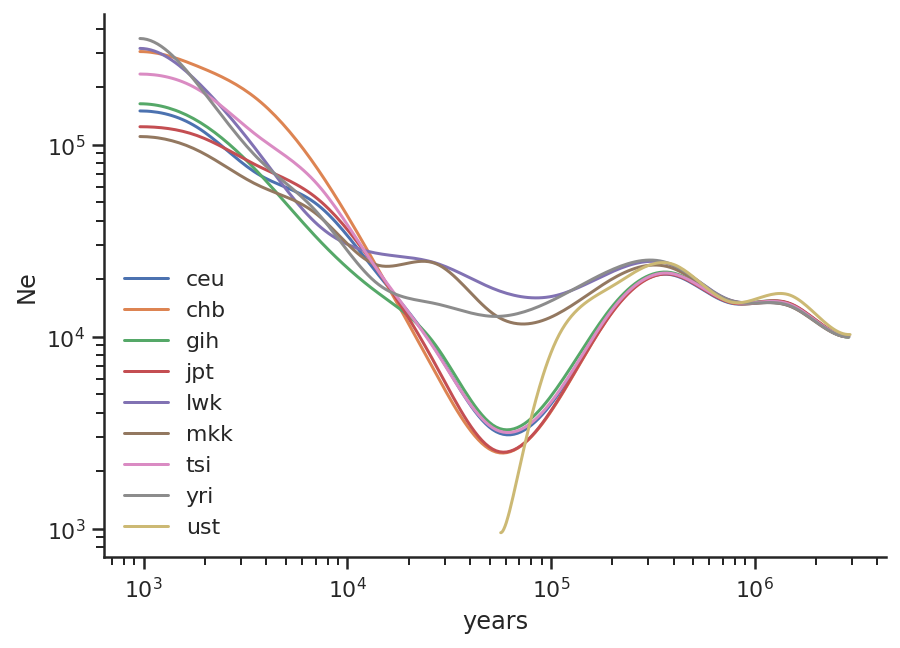

In [161]:
with sns.axes_style('ticks') :
    fig, ax = plt.subplots(figsize=(7,5))
    sns.lineplot(data=terhorst_data, x='years', y='Ne', hue='population', ax=ax)
    ax.set_xscale('log')
    ax.set_yscale('log')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:], frameon=False)
    sns.despine()

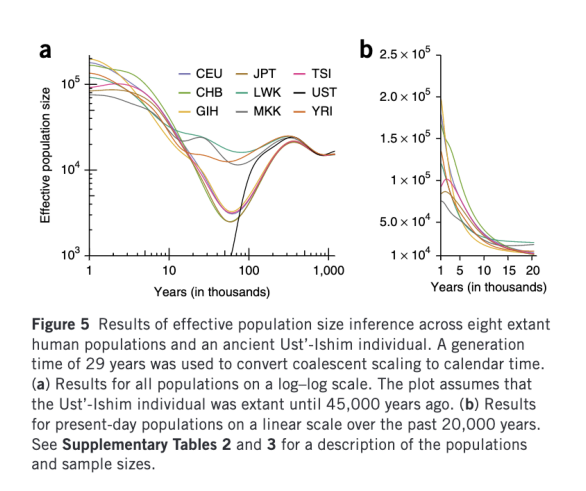

In [162]:
from matplotlib.image import imread
fig, ax = plt.subplots(figsize=(5, 5))
imgplot = ax.imshow(imread('Terhorst2017.png'))
plt.axis('off') ;

We use the CEU demography:

In [163]:
terhorst_pop = 'ceu'
years = terhorst_data.loc[terhorst_data.population == terhorst_pop, 'years'].reset_index(drop=True)
n = terhorst_data.loc[terhorst_data.population == terhorst_pop, 'Ne'].reset_index(drop=True)

Scale to fit my generation time and mutation rate:

In [164]:
terhorst_mut_rate_per_gen = 1.25e-8
years *= terhorst_mut_rate_per_gen / (ag.auto_mut_per_year * ag.gen_time) 
n *= terhorst_mut_rate_per_gen / (ag.auto_mut_per_year * ag.gen_time) 

Add end of last lasts interval (start of simulation):

In [165]:
years.at[len(years)-1] = sim_generations * ag.gen_time

Format demography:

In [166]:
terhorst_auto_demography = list(zip(list(map(int, reversed(years))), list(map(int, reversed(n)))))
terhorst_slim_demography = [(years2gen(y), int(n)) for (y, n) in terhorst_auto_demography]

Compute pool-nielsen correction:

In [167]:
epoques = get_epoques_from_demog(terhorst_slim_demography)
pool_nielsen_expected_pi = 2 * ag.auto_mut_per_year * ag.gen_time * epoch(epoques, 1, 0)
pool_nielsen_correction = autosome_pi / pool_nielsen_expected_pi
pool_nielsen_correction, autosome_pi, pool_nielsen_expected_pi

(1.4368424405725138, 0.000813939675808206, 0.000566478030453979)

Correct demography to make it fit autosomal pi:

In [168]:
terhorst_auto_demography_corrected = \
    [(int(round((g*pool_nielsen_correction))), int(round(N*pool_nielsen_correction))) for (g, N) in terhorst_auto_demography]
terhorst_auto_demography_corrected[0] = (terhorst_auto_demography[0][0], terhorst_auto_demography_corrected[0][1]) 
assert terhorst_auto_demography_corrected == sorted(terhorst_auto_demography_corrected, reverse=True)

Make corresponding slim demography:

In [169]:
terhorst_slim_demography_corrected = [(years2gen(y), int(n)) for (y, n) in terhorst_auto_demography_corrected]

Check correction:

In [170]:
epoques = get_epoques_from_demog(terhorst_slim_demography_corrected)
pool_nielsen_correction, 2 * ag.auto_mut_per_year * ag.gen_time * epoch(epoques, 1, 0), autosome_pi, epoch(epoques, 1, 0) / 2

(1.4368424405725138,
 0.0008139525091705876,
 0.000813939675808206,
 13364.630546080249)

### Tennesen demography

This is the demography we use for simulations. It is often cited at the Tennessen demography, but it is actually from a Gravel paper:
 
Gravel et al. "Demographic history and rare allele sharing among human populations". 

We use the CEU demography file that we have from Aron Stern's CLUES paper.

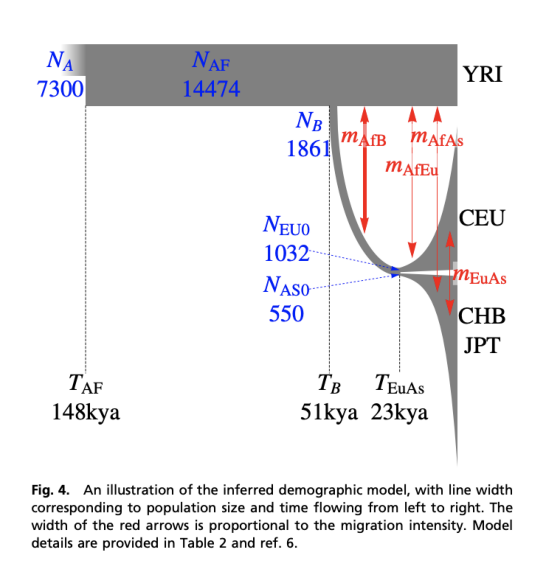

In [171]:
fig, ax = plt.subplots(figsize=(5, 5))
imgplot = ax.imshow(imread('Tennessen.png'))
plt.axis('off') ;

Load demography data and rescale population sizes to fit the generation time and mutation rate assumed in this study:

In [187]:
# load Compare to "tennessen_fine"
tennessen = pd.read_csv('/home/kmt/simons/faststorage/people/kmt/data/tennessen_popsize_fine.txt', sep='\t', header=None, names=['start', 'popsize'])

# drop the last ten entries. they just keep going with the same pop size.
# That way I get some room to scale the demography
tennessen = tennessen.iloc[:-10]

Scale to use my mutation rate and generation time:


## How should I scale below? 



In [188]:
#tennessen_mut_rate_per_gen / (ag.auto_mut_per_year * ag.gen_time) 

In [189]:
tennessen_mut_rate_per_gen = 2.36e-08
tennessen_generation_time = 25
tennessen['popsize'] *= tennessen_mut_rate_per_gen / (ag.auto_mut_per_year * ag.gen_time) 
tennessen['start'] = tennessen.start * tennessen_generation_time * 2
tennessen = tennessen[:-1] # drop last row because we do not want to simulate all the way back from 15 mill years.
tennessen['end'] = tennessen.start.shift(-1)
tennessen.at[len(tennessen)-1, 'end'] = sim_generations * ag.gen_time
tennessen = stairs(tennessen)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(tennessen)

Format demography:

In [190]:
tennessen_x, tennssen_y = tennessen.pos.tolist(), tennessen.popsize.tolist()
tennessen_auto_demography = list(zip(reversed(tennessen_x[1::2]), reversed(tennssen_y[1::2])))
tennessen_slim_demography = [(years2gen(y), int(n)) for (y, n) in tennessen_auto_demography]  ## using auto

Compute pool-nielsen correction:

In [191]:
epoques = get_epoques_from_demog(tennessen_slim_demography)
pool_nielsen_expected_pi = 2 * ag.auto_mut_per_year * ag.gen_time * epoch(epoques, 1, 0)
pool_nielsen_correction = autosome_pi / pool_nielsen_expected_pi    
pool_nielsen_correction, autosome_pi, pool_nielsen_expected_pi  

(1.434866201420952, 0.000813939675808206, 0.0005672582398290233)

In [192]:
# epoques = get_epoques_from_demog(tennessen_slim_demography)
# pool_nielsen_expected_pi = 2 * ag.auto_mut_per_year * ag.gen_time * epoch(epoques, 1, 0)
# pool_nielsen_correction = westeurasian_autosome_pi / pool_nielsen_expected_pi    
# pool_nielsen_correction, westeurasian_autosome_pi, pool_nielsen_expected_pi  

Correct demography to make it fit autosomal pi:

In [193]:
tennessen_auto_demography_corrected = [(int(round((g*pool_nielsen_correction))), int(round(N*pool_nielsen_correction))) for (g, N) in tennessen_auto_demography]
tennessen_auto_demography_corrected[0] = (tennessen_auto_demography[0][0], tennessen_auto_demography_corrected[0][1]) 
assert tennessen_auto_demography_corrected == sorted(tennessen_auto_demography_corrected, reverse=True)

Make corresponding slim demography:

In [194]:
tennessen_slim_demography_corrected = [(years2gen(y), int(n)) for (y, n) in tennessen_auto_demography_corrected]

Check correction:

In [195]:
epoques = get_epoques_from_demog(tennessen_slim_demography_corrected)
pool_nielsen_correction, 2 * ag.auto_mut_per_year * ag.gen_time * epoch(epoques, 1, 0), autosome_pi, epoch(epoques, 1, 0) / 2

(1.434866201420952,
 0.0008139928612448166,
 0.000813939675808206,
 13365.293103855749)

## Slim full autosomal demographies

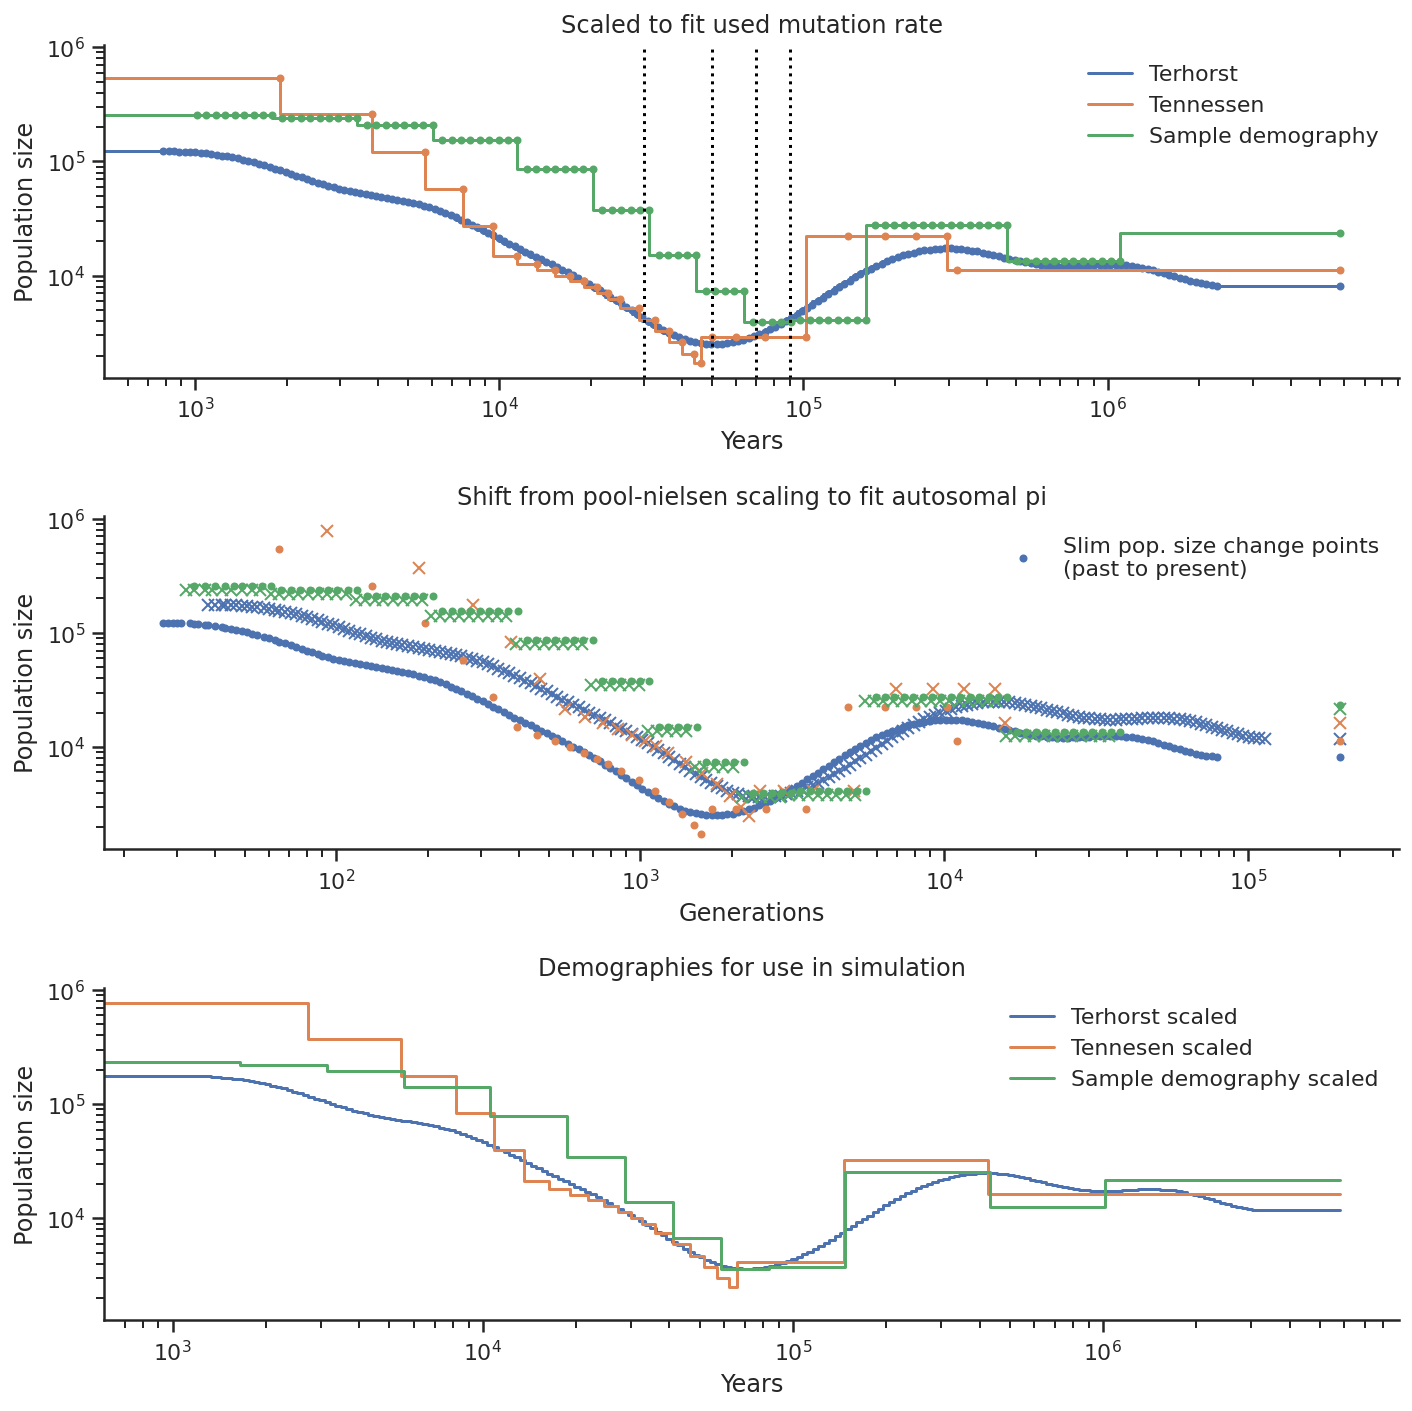

In [70]:
with sns.axes_style('ticks') :

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,10), sharey=True)
 

    def lines(demography):
        years, Ne = zip(*demography)
        y = Series(list(reversed(years)))
        n = Series(list(reversed(Ne)))
        x = [j for i in zip(y.shift(), y) for j in i]
        y = [j for i in zip(n, n) for j in i]
        x[0] = 0
        return x, y

    # terhorst
    x, y = lines(terhorst_auto_demography)
    color=next(ax1._get_lines.prop_cycler)['color']
    ax1.loglog(x, y, color=color, label='Terhorst')
    ax1.loglog(*list(zip(*terhorst_auto_demography)), marker='.', color=color, linestyle='None');

    x, y = lines(terhorst_auto_demography_corrected)
    ax3.loglog(x, y, color=color, label='Terhorst scaled')
#     ax3.loglog(*list(zip(*terhorst_auto_demography_corrected)), marker='x', color=color, linestyle='None');

    
    # tennessen
    color=next(ax1._get_lines.prop_cycler)['color']
    x, y = lines(tennessen_auto_demography)    
    ax1.loglog(x, y, color=color, label='Tennessen')
    ax1.loglog(*list(zip(*tennessen_auto_demography)), marker='.', color=color, linestyle='None');

    x, y = lines(tennessen_auto_demography_corrected)
    ax3.loglog(x, y, color=color, label='Tennesen scaled')
#     ax3.loglog(*list(zip(*tennessen_auto_demography_corrected)), marker='x', color=color, linestyle='None');
    
    
    # sampledemog
    color=next(ax1._get_lines.prop_cycler)['color']
    x, y = lines(sampledemog_auto_demography)    
    ax1.loglog(x, y, color=color, label='Sample demography')
    ax1.loglog(*list(zip(*sampledemog_auto_demography)), marker='.', color=color, linestyle='None');

    x, y = lines(sampledemog_auto_demography_corrected)
    ax3.loglog(x, y, color=color, label='Sample demography scaled')
#    ax3.loglog(*list(zip(*sampledemog_auto_demography_corrected)), marker='x', color=color, linestyle='None');
    
     
    

    
    color=next(ax2._get_lines.prop_cycler)['color']        
    g, n = list(zip(*terhorst_slim_demography))
    ax2.loglog([sim_generations-x for x in g], n, marker='.', color=color, linestyle='None', 
               label='Slim pop. size change points\n(past to present)');

    g, n = list(zip(*terhorst_slim_demography_corrected))
    ax2.loglog([sim_generations-x for x in g], n, marker='x', color=color, linestyle='None');

    color=next(ax2._get_lines.prop_cycler)['color']            
    g, n = list(zip(*tennessen_slim_demography))
    ax2.loglog([sim_generations-x for x in g], n, marker='.', color=color, linestyle='None');

    g, n = list(zip(*tennessen_slim_demography_corrected))
    ax2.loglog([sim_generations-x for x in g], n, marker='x', color=color, linestyle='None');
    
    color=next(ax2._get_lines.prop_cycler)['color']            
    g, n = list(zip(*sampledemog_slim_demography))
    ax2.loglog([sim_generations-x for x in g], n, marker='.', color=color, linestyle='None');

    g, n = list(zip(*sampledemog_slim_demography_corrected))
    ax2.loglog([sim_generations-x for x in g], n, marker='x', color=color, linestyle='None');
    
    
    # sweeps:
    [ax1.axvline(x, linestyle='dotted', color='black') for x in sweep_years]

    ax1.set_title('Scaled to fit used mutation rate')
    ax1.set_xlabel('Years')
    ax1.set_ylabel('Population size')
    ax1.legend(frameon=False)

    ax2.set_title('Shift from pool-nielsen scaling to fit autosomal pi')
    ax2.set_xlabel('Generations')
    ax2.set_ylabel('Population size')
    ax2.legend(frameon=False)
    
    ax3.set_title('Demographies for use in simulation')
    ax3.set_xlabel('Years')
    ax3.set_ylabel('Population size')
    ax3.legend(frameon=False)

    sns.despine()
    
    plt.tight_layout()

In [71]:
mut_rate_x_auto_ratio = ((1/3) * (3/4) + (2/3) * (1/4)) / ((1/2) * (3/4) + (1/2) * (1/4))
4.3e-10 * 1.22 * mut_rate_x_auto_ratio

4.3716666666666666e-10

### See if demography produces the X/A ratios reported in Mallick et al

Reading off from the plot in Mallick et al., the African X/A pi is 0.66 and the non-African one is 0.55.

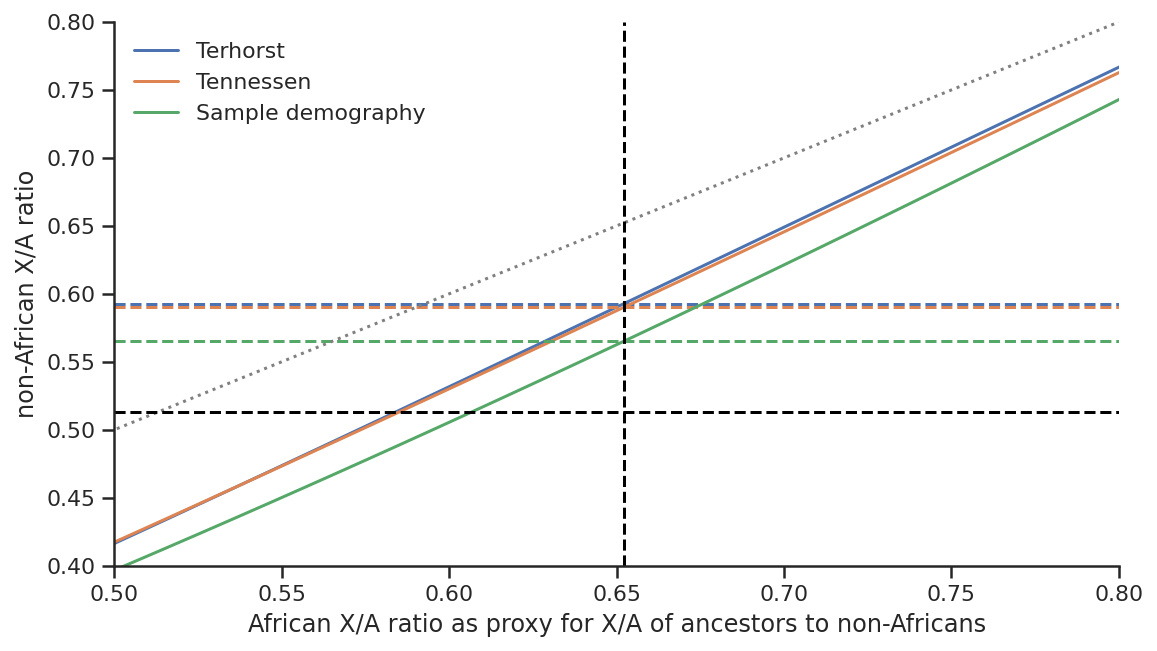

In [72]:
with sns.axes_style('ticks') :

    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
 
    color=next(ax._get_lines.prop_cycler)['color']
    epoques = get_epoques_from_demog(terhorst_slim_demography_corrected)
    x = np.linspace(0.001, 1, 100)
    y = [epoch(epoques, h, 0) / epoch(epoques, 1, 0) for h in x]
    plt.plot(x, y, label='Terhorst', color=color)
    plt.axhline(epoch(epoques, afr_x_auto, 0) / epoch(epoques, 1, 0), color=color, linestyle='dashed')

    color=next(ax._get_lines.prop_cycler)['color']
    epoques = get_epoques_from_demog(tennessen_slim_demography_corrected)
    x = np.linspace(0.001, 1, 100)
    y = [epoch(epoques, h, 0) / epoch(epoques, 1, 0) for h in x]
    plt.plot(x, y, label='Tennessen', color=color)
    plt.axhline(epoch(epoques, afr_x_auto, 0) / epoch(epoques, 1, 0), color=color, linestyle='dashed')

    color=next(ax._get_lines.prop_cycler)['color']
    epoques = get_epoques_from_demog(sampledemog_slim_demography_corrected)
    x = np.linspace(0.001, 1, 100)
    y = [epoch(epoques, h, 0) / epoch(epoques, 1, 0) for h in x]
    plt.plot(x, y, label='Sample demography', color=color)
    plt.axhline(epoch(epoques, afr_x_auto, 0) / epoch(epoques, 1, 0), color=color, linestyle='dashed')
    
    plt.legend(frameon=False)
    
    plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), color='grey', linestyle='dotted')
    plt.axvline(afr_x_auto, color='black', linestyle='dashed')
    plt.axhline(nonafr_x_auto, color='black', linestyle='dashed')
    
    plt.ylabel('non-African X/A ratio')
    plt.xlabel('African X/A ratio as proxy for X/A of ancestors to non-Africans')
    plt.xlim(0.5, 0.8)
    plt.ylim(0.4, 0.8)
    
    sns.despine()

The two demographies produce similar X/A ratios in non-Africans, but they are both considerably higher than the observed one.

If we assume that sweeps remove half of diversity in the 11% we report as covered by ECHs, then the expected X/A ratios are instead:

In [73]:
missing_proportion = 0.5 * 0.11

epoques = get_epoques_from_demog(terhorst_slim_demography_corrected)
print((1 / (1 - missing_proportion) * epoch(epoques, 0.66, 0)) / epoch(epoques, 1, 0))

epoques = get_epoques_from_demog(tennessen_slim_demography_corrected)
print((1 / (1 - missing_proportion) * epoch(epoques, 0.66, 0)) / epoch(epoques, 1, 0))

epoques = get_epoques_from_demog(sampledemog_slim_demography_corrected)
print((1 / (1 - missing_proportion) * epoch(epoques, 0.66, 0)) / epoch(epoques, 1, 0))

0.6369849633984542
0.6339959100646941
0.6076029859195985


... which is somewhat closer to the observed ratio.

## Find recombination rates relevant for simulations

Lift over regions to hg38

In [182]:
print(extended_peak_regions_10[['chrom', 'start_pos', 'end_pos']].to_string(index=False))

chrom  start_pos    end_pos
 chrX   19300000   20400000
 chrX   20700000   21700000
 chrX   35900000   37100000
 chrX   37000000   37800000
 chrX   49500000   50000000
 chrX   50800000   51300000
 chrX   53900000   54700000
 chrX   64400000   65200000
 chrX   72700000   73500000
 chrX   73800000   74400000
 chrX   76700000   77400000
 chrX   98300000   99200000
 chrX  109200000  111600000
 chrX  113800000  114500000
 chrX  126400000  127700000
 chrX  129500000  130200000
 chrX  130900000  132300000
 chrX  132400000  133100000
 chrX  153900000  154500000


Used online liftover to convert to hg38 allowing, un-checking box to dis-allow multiple output regions. Minimum ratio of bases that must remap to 0.9 (default is 0.95, but that makes one region not remap, it does so at 0.93). Otherwise default parameters. Result pasted in below:

In [183]:
# lifted = '''
# chrX	19281882	20381882	chrX:19300001-20400000	1
# chrX	20681882	21681882	chrX:20700001-21700000	1
# chrX	35881883	37080183	chrX:35900001-37100000	1
# chrX	36981927	37940747	chrX:37000001-37800000	1
# chrX	49735397	50209447	chrX:49500001-50000000	1
# chrX	50057375	50057403	chrX:49500001-50000000	2
# chrX	51057154	51557148	chrX:50800001-51300000	1
# chr2	33174181	33174306	chrX:50800001-51300000	2
# chrX	53873573	54673567	chrX:53900001-54700000	1
# chrX	65180120	65980158	chrX:64400001-65200000	1
# chrX	73480164	74280165	chrX:72700001-73500000	1
# chrX	74580165	75180165	chrX:73800001-74400000	1
# chrX	77448201	78144503	chrX:76700001-77400000	1
# chrX	99045002	99945002	chrX:98300001-99200000	1
# chrX	109956772	112356772	chrX:109200001-111600000	1
# chrX	114565551	115265429	chrX:113800001-114500000	1
# chrX	78550431	78550462	chrX:113800001-114500000	2
# chrX	114761888	114761918	chrX:113800001-114500000	3
# chrX	114761888	114761980	chrX:113800001-114500000	4
# chrX	127266017	128566022	chrX:126400001-127700000	1
# chrX	130366026	131066026	chrX:129500001-130200000	1
# chrX	131765972	133165972	chrX:130900001-132300000	1
# chrX	133265972	133965973	chrX:132400001-133100000	1
# chrX	154671726	155270710	chrX:153900001-154500000	1
# '''

<!-- Conversion failed for :

    #Partially deleted in new
    chrX	37000000	37800000 -->

In [184]:
lifted = '''
chrX	19281882	20381882
chrX	20681882	21681882
chrX	35881883	37080183
chrX	36981927	37940747
chrX	49735397	50209447
chrX	51057154	51557148
chrX	53873573	54673567
chrX	65180120	65980158
chrX	73480164	74280165
chrX	74580165	75180165
chrX	77448201	78144503
chrX	99045002	99945002
chrX	109956772	112356772
chrX	114565551	115265429
chrX	127266017	128566022
chrX	130366026	131066026
chrX	131765972	133165972
chrX	133265972	133965973
chrX	154671726	155270710
'''

Extract recombination rates for regions:

In [185]:
records = list()
for row in lifted.strip().split('\n'):
    records.append([x.isdigit() and int(x) or x for x in row.split()])
extended_peak_regions_10_hg38 = pd.DataFrame.from_records(records, 
#                                     columns=['chrom', 'start', 'end', 'segment', 'piece'])
                                    columns=['chrom', 'start', 'end'])
extended_peak_regions_10_hg38.head()

,chrom,start,end
0,chrX,19281882,20381882
1,chrX,20681882,21681882
2,chrX,35881883,37080183
3,chrX,36981927,37940747
4,chrX,49735397,50209447


Load recombination rate from Halldorsson et al. 2019: "Characterizing mutagenic effects of recombination through a sequence-level genetic map". Rates are per generation, also for the X chromosome (i.e. the maternal rate and sex average rates are the same).

In [186]:
decode_sexavg = pd.read_table(ag.data_dir / 'decode_hg38_sexavg_per_gen.tsv', comment='#')
decode_sexavg.head()

,Chr,Begin,End,cMperMb,cM
0,chr1,1431813,1515567,0.032449,0.002718
1,chr1,1515567,1530002,0.189597,0.005455
2,chr1,1530002,1534402,0.004631,0.005475
3,chr1,1534402,1538787,0.019865,0.005562
4,chr1,1538787,1541864,0.000332,0.005563


Mean rate of (similar sized) chromosome 7 and mean autosomal rate:

In [187]:
decode_sexavg_chr7 = decode_sexavg.loc[(decode_sexavg['Chr'] == 'chr7')]
mean_rate_chr7 = np.average(decode_sexavg_chr7.cMperMb, weights=decode_sexavg_chr7.End-decode_sexavg_chr7.Begin)
mean_rate_chr7

1.1278006767458615

Mean rate for entire X chromosome excluding PARs:

In [188]:
decode_sexavg_chrX = (decode_sexavg
                      .loc[(decode_sexavg['Chr'] == 'chrX') & \
                           (decode_sexavg['Begin'] > ag.par1_end) & (decode_sexavg['End'] < ag.par2_start)]
                     )
mean_rate = np.average(decode_sexavg_chrX.cMperMb, weights=decode_sexavg_chrX.End-decode_sexavg_chrX.Begin)
mean_rate

1.1628671122887646

Mean rate in each ECH region:

In [189]:
records = list()
for tup in extended_peak_regions_10_hg38.itertuples():
    single_reg = decode_sexavg_chrX.loc[(decode_sexavg_chrX.Begin >= tup.start) & \
                                         (decode_sexavg_chrX.End <= tup.end)]

    np.average(single_reg.cMperMb, weights=single_reg.End-single_reg.Begin)
    
    records.append(( np.average(single_reg.cMperMb, weights=single_reg.End-single_reg.Begin), 
                    (single_reg.End-single_reg.Begin).sum()))

region_mean_rates = pd.DataFrame().from_records(records, columns=['mean_rate', 'tot_length'])
region_mean_rates

,mean_rate,tot_length
0,7.714961e-01,1090037
1,1.479958e-01,995497
2,5.999632e-01,1174337
3,6.853079e-01,928294
4,4.367416e-01,465754
5,3.881414e-01,460999
6,6.182831e-01,796095
7,6.045130e-02,787887
8,5.536945e-02,754082
9,3.336512e-02,478934


Mean (sex averaged) per-generation recombination rate for all sequence spanned by regions:

In [190]:
df_list = list()
for tup in extended_peak_regions_10_hg38.itertuples():
    df_list.append(decode_sexavg_chrX.loc[(decode_sexavg_chrX.Begin >= tup.start) & (decode_sexavg_chrX.End <= tup.end)])
df = pd.concat(df_list)

In [191]:
extended_peak_regions_10_mean_rate = np.average(df.cMperMb, weights=df.End-df.Begin)
extended_peak_regions_10_mean_rate

0.4614656569905098

Plot distribution of recombination rate in 1Mb windows along X chromosome to see how typical the lower recombination rates are:

In [192]:
decode_sexavg_chrX.head()

,Chr,Begin,End,cMperMb,cM
1122949,chrX,3532526,3533229,2.641418e-01,0.000186
1122950,chrX,3533229,3534231,1.352181e+00,0.001541
1122951,chrX,3534231,3535643,2.552302e-64,0.001541
1122952,chrX,3535643,3551002,2.618438e-60,0.001541
1122953,chrX,3551002,3580516,1.997509e-54,0.001541


In 1Mb windows:

In [193]:
@window(size=1000000)
def mean_window_rate(df):
    if len(df):
        return np.average(df.cMperMb, weights=df.end-df.start)
    else:
        return np.nan

window_means_1mb = mean_window_rate(decode_sexavg_chrX.rename(columns={'Begin':'start', 'End':'end'}))
#window_means_1mb.head()

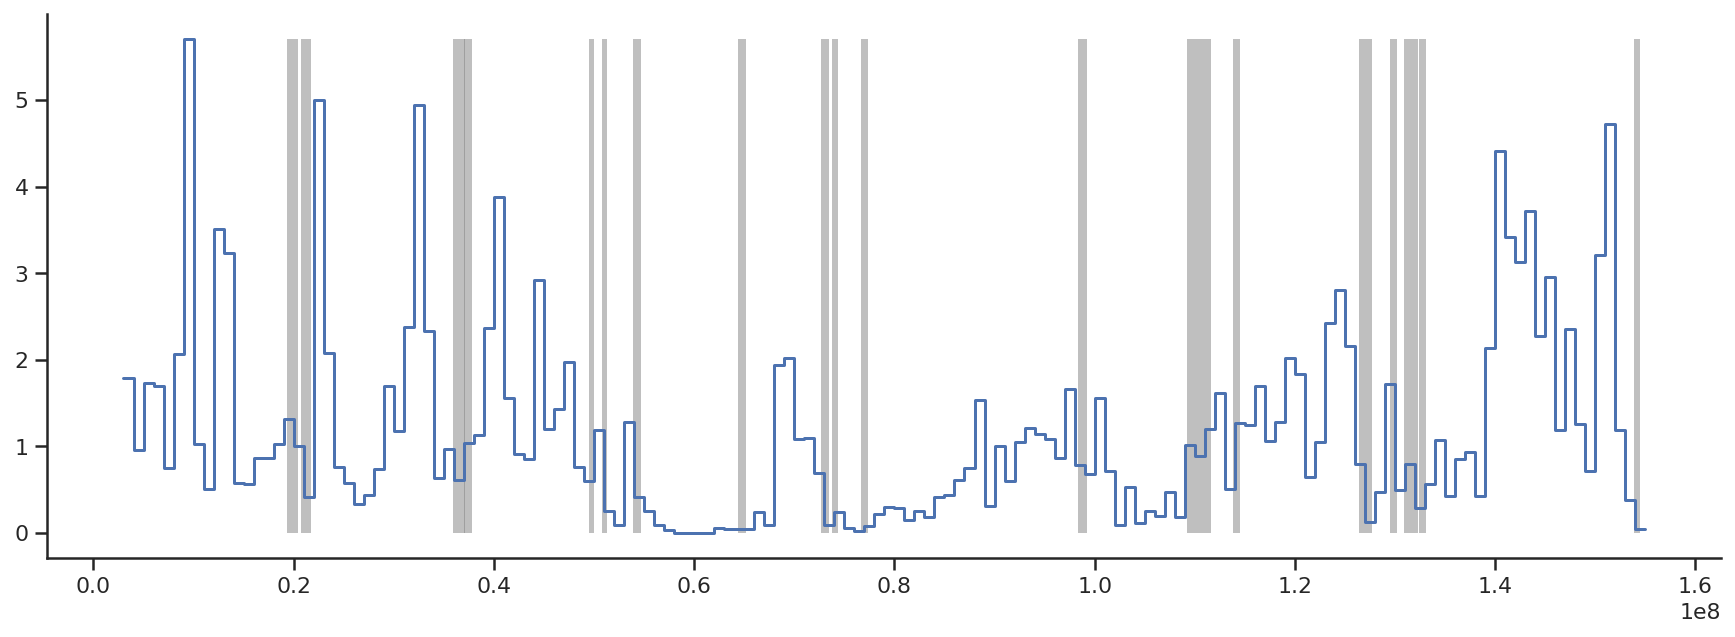

In [194]:
with sns.axes_style('ticks'):
    plot_df = stairs(window_means_1mb)
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    for tup in extended_peak_regions_10.itertuples():
        g = ax.add_patch(Rectangle((tup.start_pos, 0), 
                                   tup.end_pos-tup.start_pos, plot_df.mean_window_rate.max(), 
                     facecolor='gray',
                     linewidth=0,
                     alpha=0.5,
                     zorder=0))
    plt.plot(plot_df.pos, plot_df.mean_window_rate)
    sns.despine()

In 100kb windows:

In [195]:
@window(size=100000)
def mean_window_rate(df):
    if len(df):
        return np.average(df.cMperMb, weights=df.end-df.start)
    else:
        return np.nan

window_means_100kb = mean_window_rate(decode_sexavg_chrX.rename(columns={'Begin':'start', 'End':'end'}))
#window_means_100kb.head()

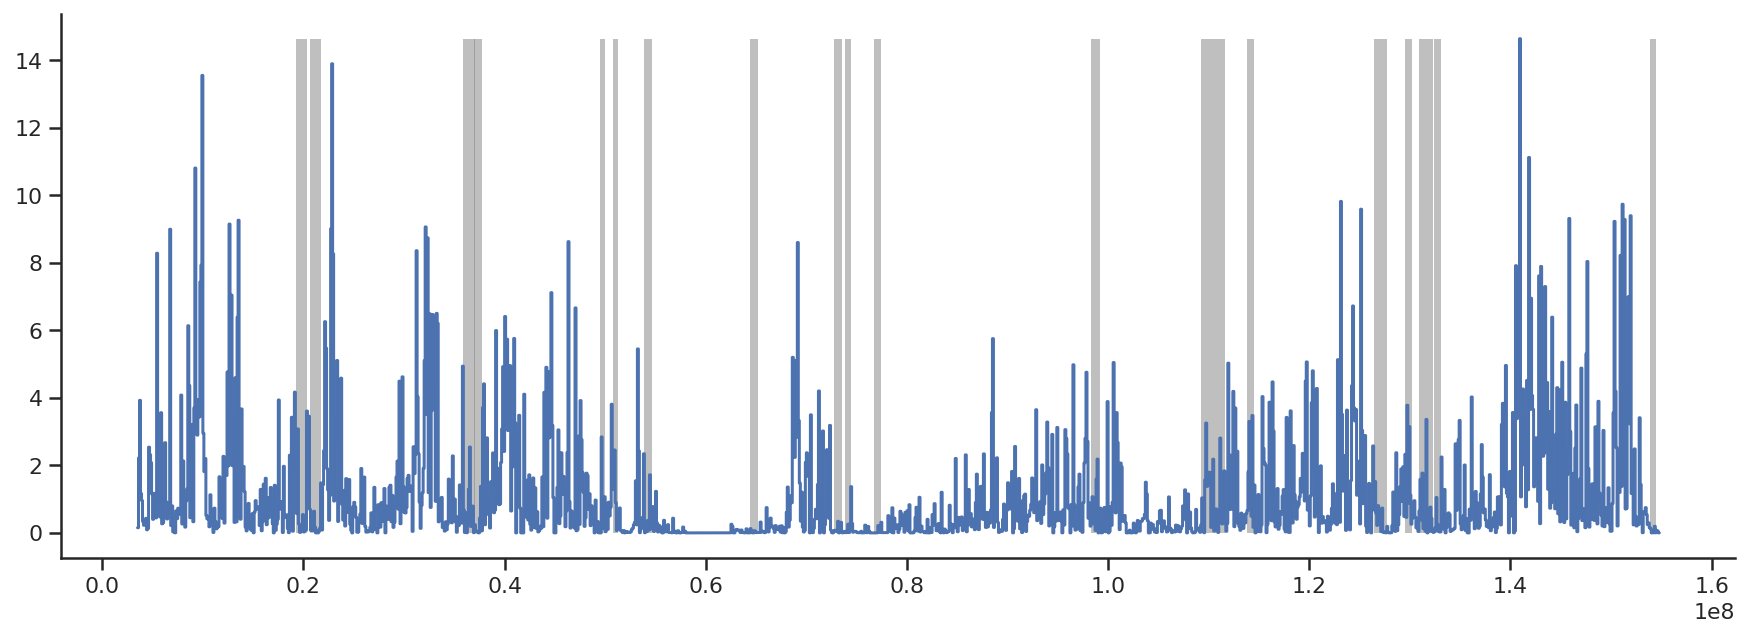

In [196]:
with sns.axes_style('ticks'):
    plot_df = stairs(window_means_100kb)
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    for tup in extended_peak_regions_10.itertuples():
        g = ax.add_patch(Rectangle((tup.start_pos, 0), 
                                   tup.end_pos-tup.start_pos, plot_df.mean_window_rate.max(), 
                     facecolor='gray',
                     linewidth=0,
                     alpha=0.5,
                     zorder=0))
    plt.plot(plot_df.pos, plot_df.mean_window_rate)
    sns.despine()

So although the ECH regions have lower recombination rate, they are not uniquely low. There are plenty other regions that are equally low.

See where each ECH region falls in the distribution of recombination rate in 500kb windows:

In [197]:
@window(size=500000)
def mean_window_rate(df):
    if len(df):
        return np.average(df.cMperMb, weights=df.end-df.start)
    else:
        return np.nan

window_means_by_chrom = (decode_sexavg
                            .rename(columns={'Chr':'chrom', 'Begin':'start', 'End':'end'})
                            .groupby('chrom')
                            .apply(mean_window_rate)
                            .reset_index()
                           )
window_means_by_chrom['chrom_type'] = 'Autosome'
window_means_by_chrom.loc[window_means_by_chrom.chrom == 'chrX', 'chrom_type'] = 'X'

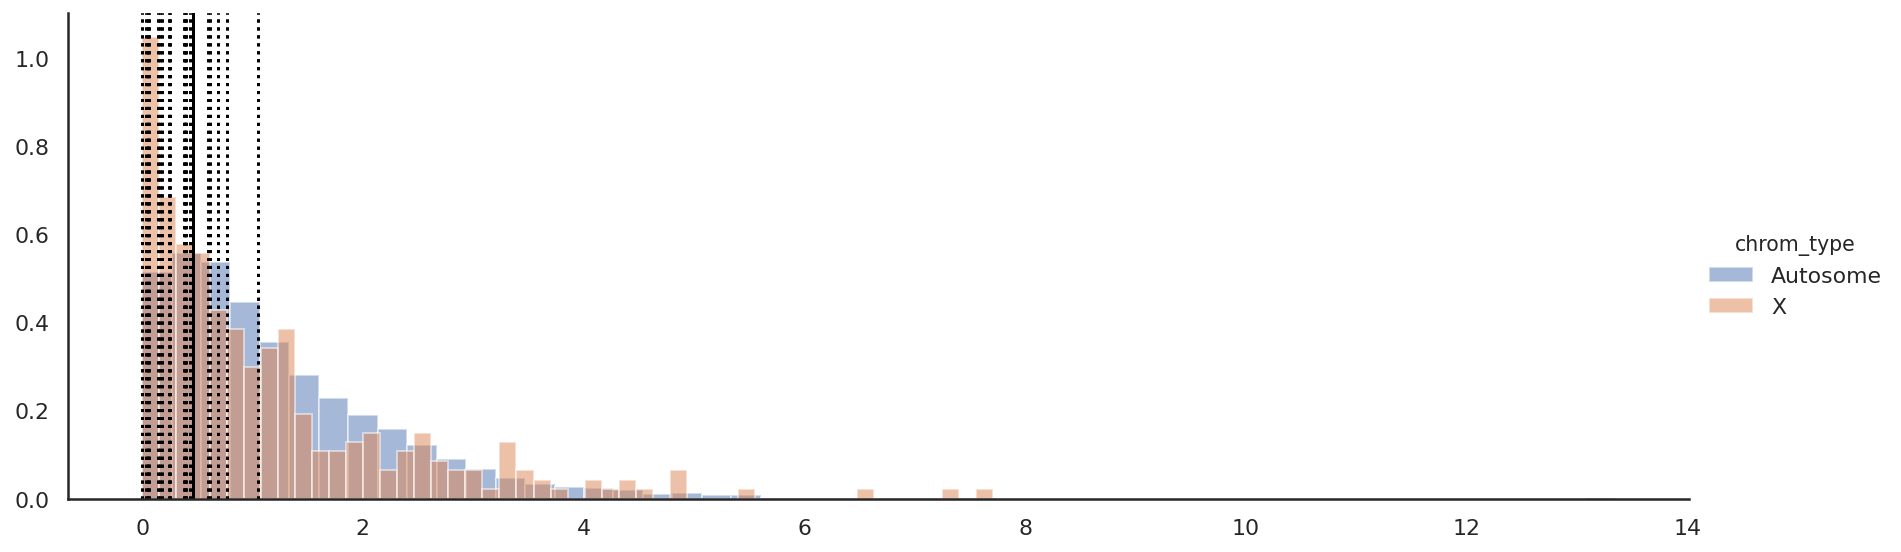

In [198]:
def axvline(x, **kwargs):
    plt.axvline(x, **kwargs)
    
with sns.axes_style('white'):
    g = sns.FacetGrid(data=window_means_by_chrom, hue='chrom_type',  
                      sharex=True, sharey=True,
                      height=4, aspect=3)
    g.map(plt.hist, 'mean_window_rate', bins=50, density=True, alpha=0.5)
    g.map(plt.axvline, x=extended_peak_regions_10_mean_rate, ls="-",  color='black') ;
    for r in region_mean_rates.mean_rate:
        g.map(plt.axvline, x=r, ls=":",  color='black') ;

    g.add_legend()

It seems that on a 500kb scale, which is the one relevant to ECHs, the mean recombination rate or ECH recions is as frequent on X than on autosomes. In fact the ECH region rate seems to the most common rate on autosomes. So low recombination rate *by itself* does not seem to determine occurence of ECHs.

## Simulation strategy

- We use the sample demography for simulation.
- We run four sets of neutral simulations varying recombination rate and reduction in Ne due to background selection. The X/A ratio is always **0.65**. This is the X/A ratio of Africans, which should capture the various demographic forces reducing Ne on X below 3/4.
- We use two values for further scaling Ne: No scaling: **1** representing the mean Ne on chrX, and a scaling of **0.71** to represent the lower local Ne in ECH regions.
- We use two recombination rates: **1.16** cM/Mb representing chromosome mean and **0.46** cM/Mb representing ECH region mean.
- Use different mutation rates for simulating X and autosomes:

```
ag.auto_mut_per_year = ag.mut_per_year / ag.mut_rate_x_auto_ratio # 5.250300000000001e-10
ag.mut_rate_x_auto_ratio = ((1/3) * 0.8 + (2/3) * 0.2) / ((1/2) * 0.8 + (1/2) * 0.2) # 0.8
ag.mut_per_year = 4.3e-10 * 1.221 * ag.mut_rate_x_auto_ratio # 4.200240000000001e-10
```

- We use SLiM to simulate 10Mb alignmnets of 140 haplotypes corresponding to the analyzed non-African samples. We use **autosomal** population sizes for Slim because it models the X chrom explicitly. To make the X/A ratio lower than 0.75 we scale the population sizes by (e.g. 0.66/0.75) when running the slim simulation.
- On each set of simulated haplotypes, we compute allele frequencies, LD decay.
- ECHs are then called on each simulated data set.
- Since we only simulate the non-Africans, we use a min_sweep_clade cutoff that corresponds to the same percentage of nan-Africans:

In [204]:
nr_non_africans = 140
nr_africans = 22
ag.min_sweep_clade_size / 162
int(round((ag.min_sweep_clade_size / (nr_africans + nr_non_africans)) * (nr_africans + nr_non_africans) / nr_non_africans  * 100))

30

Generation-Ne pairs for changeing population size in Slim simulation (for adding to `workflow_simons.py`). SLiM only needs the change points in Ne. So we only need tuples where Ne changes:

In [205]:
sampledemog_slim_demography_simplified = [sampledemog_slim_demography[0]]
for i in range(1, len(sampledemog_slim_demography)):
    if sampledemog_slim_demography[i][1] != sampledemog_slim_demography[i-1][1]:
        sampledemog_slim_demography_simplified.append(sampledemog_slim_demography[i])
sampledemog_slim_demography_simplified

[(1, 23434),
 (162010, 13579),
 (183858, 27616),
 (194462, 4107),
 (196870, 3936),
 (197809, 7343),
 (198466, 15066),
 (198926, 37591),
 (199300, 86151),
 (199604, 153716),
 (199791, 210671),
 (199882, 239151),
 (199938, 255465)]

In [202]:
#sampledemog_slim_demography